# AWS IoT Analytics | Smart City Air Quality Forecasting

Applying LSTM to the prediction of particulate pollution in city centers.</p>

Environmental monitoring is a form of situational awareness and is a key use case for IoT in many industries. Environmental monitoring, unlike many multivariate forecasting problems in IoT which build predictive models from multiple sensors on a single device, involves multiple sensors on distributed devices. Here we are interested in forecasting an environmental state--the air quality in Beijing--based on data from distributed sensors placed around the US Embassy and Beijing Capital International Airport. Because physically separate sensors can generate very different data, we will first visually explore the data. Our visual data exploration will focus on the correlation between the sensor measurements and variance within each reading. This helps us select the data processing and machine learning techniques most appropriate to our data.     

In this template, we are using environmental sensor readings taken over a 5-year period to forecast air pollution trends in an urban environment. Our sample data set consists of hourly readings from environmental sensors around Beijing, China. The data set includes a pm2.5 reading which is an atmospheric particulate measurement associated with air pollution. Like many real data sets this one includes missing data, extraneous columns and potentially false readings. We will show how these can be addressed through data processing steps. 

## Set-up: Import Required Notebook Libraries

<p>This Notebook requires a few basic Python libraries including <a href="http://pandas.pydata.org/">`pandas`</a>, <a href="http://www.numpy.org/">`numpy`</a>, <a href="https://mxnet.incubator.apache.org/">`mxnet`</a>, <a href="https://docs.python.org/2/library/datetime.html">`datetime`</a>, <a href="scikit-learn.org"> `scikit-learn` </a> and <a href="https://matplotlib.org/">`matplotlib`</a>.</p>

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import sys
import sklearn

## Background: Problem Description and Approach

As mentioned in the introduction, the environmental state, whether it is air quality or water quality, is a common use case for IoT systems. For example, engine manufacturers need to know the purity of intake air to predict engine maintenance patterns across geographic regions. Farmers need to know water quality to protect crops from salt water infiltration in wells or other irrigation sources.  For this Notebook, we'll be predicting particulate levels, a key component of air pollution, in the city of Beijing, China using 5 years of historical weather and air quality data. 

We'll need to inspect our data set before we determine the required data processing steps and to ensure that our chosen prediction technique, a recurrent neural network called 'Long Short-Term Memory' (<a href="https://en.wikipedia.org/wiki/Long_short-term_memory">LSTM</a>) is approporiate. LSTM offers a number of advantages for predicting situational awareness in IoT systems but chief among them is its handling of trends occurring at different time scales. In our environmental monitoring example, weather has an annual seasonality, but particulate rates also vary by the work week and the number of vehicles on the road.  

<img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="float:left;height:20px;"></img><b style="color:#1A5276;padding-left:5px;">HUMAN LEARNING NOTE</b> For more information on the approach taken in this Notebook, click the [link](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/). Note that we are using `Apache MXNet` as a machine learning library supporting our LSTM model.

<h1 style="color:#20B3CD;font-size:20px;float:left">Step 1  |  Loading Data </h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:70%"></div>

### Data Set Description

Environmental monitoring often requires joining data across multiple devices. However, there are two main sources of IoT environmental data. The first is collected from expensive, high quality sensors used by governments for regulated air quality survellience and by companies for process control and worker safety. The second is collected by citizen scientists and start-ups for crowd-sourced experimentation and health monitoring and uses low cost, low power, and often unreliable DIY hardware. Although the sensor measurements may look exactly the same from both installation types, the citizen scientist tends to have broader geographic coverage and hence higher data volume and granularity, but this data also suffers from more missing data points and false sensor readings. This noisiness of the DIY data and sparseness of the professional data represent two different challenges to forecasting air particulate levels. 

Our sample data set faces both these challenges because it contains particulate counts sourced from devices at the US Embassy in Beijing with missing data points (designated by NA in the data set) and weather data from official government sensors at Beijing Capital International airport. Our sample data was collected between Jan 1st, 2010 and Dec 31st, 2014 and has the following fields:   

<table style="margin-left:50px; float:left;">
<tr><td><b>No</b></td><td>row number</td></tr>
<tr><td><b>year</b></td><td>year measured</td></tr>
<tr><td><b>month</b></td><td>month measured</td></tr>
<tr><td><b>day</b></td><td>day measured</td></tr>
<tr><td><b>hour</b></td><td>hour measured</td></tr>
</table>
<table style="margin-left:50px; float:left;">
<tr><td><b>pm2.5</b></td><td>PM2.5 concentration (ug/m^3)</td></tr>
<tr><td><b>DEWP</b></td><td>dew point (C)</td></tr>
<tr><td><b>TEMP</b></td><td>temperature (C)</td></tr>
<tr><td><b>PRES</b></td><td>pressure (hPa)</td></tr>
<tr><td><b>cbwd</b></td><td>combined wind direction</td></tr>
</table>
<table style="margin-left:50px; float:left;">
<tr><td><b>Iws</b></td><td>cumulated wind speed (m/s)</td></tr>
<tr><td><b>Is</b></td><td>cumulated hours of snow</td></tr>
<tr><td><b>Ir</b></td><td>cumulated hours of rain</td></tr>
</table>


<p style="clear:both;"></p>
<p style="font-weight:bold;margin-top:50px;">Data Set Attribution:</p>
Liang, X., Zou, T., Guo, B., Li, S., Zhang, H., Zhang, S., Huang, H. and Chen, S. X. (2015). Assessing Beijing's PM2.5 pollution: severity, weather impact, APEC and winter heating. Proceedings of the Royal Society A, 471, 20150257 [https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data].


<img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="float:left;height:20px;"></img><b style="color:#1A5276;padding-left:5px;">PRODUCTION NOTE</b> The data filtering, cleansing and structuring can also be accomplished in the AWS IoT Analytics pipeline, which is used to preprocess the raw data coming from the device through an AWS IoT Analytics channel. 


We'll start by specifying the names of the data set and columns.

In [2]:
import pandas as pd
from datetime import datetime

# Function to convert date columns into a single timestamp field
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

# Definition of the data set columns
org_col_names=["No", "year","month", "day", "hour", "pm2.5", "DEWP","TEMP", "PRES", "cbwd", "Iws", "Is", "Ir"]
col_names = ['pollution', 'dew', 'temp', 'pressure', 'w_dir', 'w_speed', 'snow', 'rain']         
dataset = pd.read_csv('https://s3.amazonaws.com/iotanalytics-templates/data/PRSA_data_2010.1.1-2014.12.31.csv',  
                    index_col=0,
                    date_parser=parse,
                    parse_dates=[['year', 'month', 'day', 'hour']])

# Data cleansing to remove unwanted columns including row number
dataset.drop('No', axis=1, inplace=True)
dataset.columns = col_names

# Rename pm2.5 to pollution
dataset['pollution'].fillna(0, inplace=True)
dataset = dataset[24:] # drop the first day
print(dataset.head(5))
dataset.to_csv('pollution.csv') # save new CSV

                     pollution  dew  temp  pressure w_dir  w_speed  snow  rain
year_month_day_hour                                                           
2010-01-02 00:00:00      129.0  -16  -4.0    1020.0    SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0    1020.0    SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0    1021.0    SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0    1022.0    SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0    1022.0    SE     6.25     2     0


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Load processed data set
df = pd.read_csv('pollution.csv', header=0, index_col=0)

Let's take a look at the distribution in our data set to see how much variance we have across each value and decide what preprocessing we'll need to do on our data and what forecasting technique may work best.

In [4]:
df.describe()

,pollution,dew,temp,pressure,w_speed,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [5]:
dataset_columns = df.columns.tolist()
dataset_columns

['pollution', 'dew', 'temp', 'pressure', 'w_dir', 'w_speed', 'snow', 'rain']

For our sample air quality data set, the above statistical summary shows the count, mean, standard deviation, 25th, 50th and 75th percentile for each sensor measurement. As our sensor measurements are all on different scales, it's difficult to tell from the table where the largest variance is among our measurements. We'll dive deeper into the data in the next section.

<h1 style="color:#20B3CD;font-size:20px;float:left">Step 2  |  Exploring Data</h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:70%"></div>

To visualize the variance in our data set, we've plotted the sensor measurements in a boxplot below. A <a href="https://en.wikipedia.org/wiki/Box_plot">boxplot</a> shows the lower and upper quartiles (25th-75th percentiles) within the box with the data set skew illustrated as whiskers, and outliers shown as individual data points.  

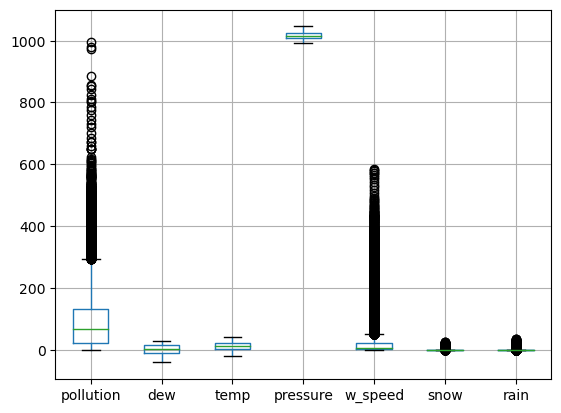

In [6]:
# Create box plot
df.boxplot()
plt.show()

In our sample data, the pollution or particulate count and wind speed have the largest standard deviation. Let's see how these parameters interact with each other by plotting a <a href="https://en.wikipedia.org/wiki/Correlation_and_dependence">correlation matrix</a>. This will tell us if a relationship exists between any of the values in our data set. If we have sensor measurements that are tightly correlated, then they carry the same information and we can discard one or more of the values without losing information. Eliminating variabes will reduce the size of the neural network layers required to forecast our system, which in turn reduces the compute resources we need to run our LSTM model. This process is referred to as reducing dimensionality in our data set.

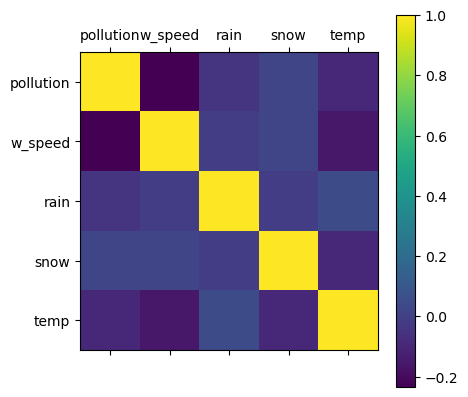

In [7]:
# select the value columns in the DataFrame to compare
cor_cols = ['pollution', 'w_speed', 'rain', 'snow', 'temp']

# plot correlation matrix
plt.matshow(df.loc[:, cor_cols].corr())
plt.xticks(range(len(cor_cols)), cor_cols)
plt.yticks(range(len(cor_cols)), cor_cols)
plt.colorbar()
plt.show()

For our sample data set, there is no strong correlation between variables. Windspeed has weak (0.2) negative correlation with pollution which makes sense as wind can cause pollution particles to disperse. None of the other parameters are correlated in a meaningful manner. 

<img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="float:left;height:20px;"></img><b style="color:#1A5276;padding-left:5px;">HUMAN LEARNING NOTE</b> On a correlation matrix, a correlation of 1 indicates that the values or variables are self-similar, i.e. the same, where a correlation of -1 indicates that the variables are opposites. A correation score of 0 indicates that there is no relationship between the variables.

To explore our data set further, let's take a look at a pairwise scatter matrix for more insights. The scatter matrix plots each variable or value against each other. This allows us to look for linear relationships between the variables which, again, would allow us to simplify our forecasting model.

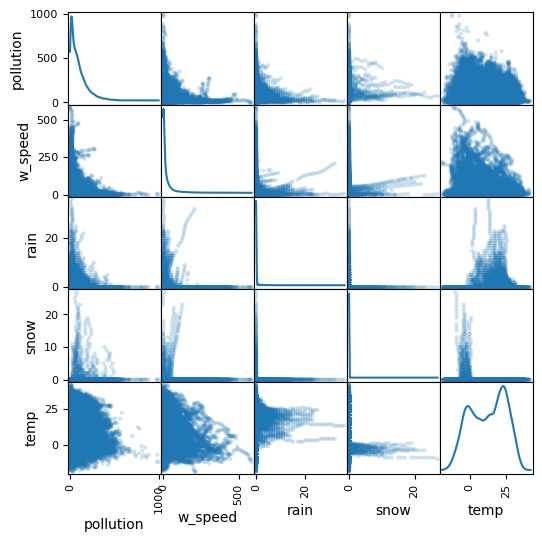

In [8]:
from pandas.plotting import scatter_matrix
data = pd.DataFrame(df.loc[:, cor_cols])
scatter_matrix(data, alpha=0.2, figsize=(6, 6), diagonal='kde')
plt.show()

For our sample data set, the scatter matrix doesn't offer any further insight into variable selection. 

<h1 style="color:#20B3CD;font-size:20px;float:left">Step 3  |  Processing Data</h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:70%"></div>

Now that we understand our data distribution, let's get our data set into the proper format for machine learning with our neural network.

### Non-numeric Label Transformation

To begin with, we'll need to convert all of our data set labels (pollution, snow, rain, etc.) into numeric values. Although LSTM can be used for text and image classification, we'll need all of our labels to be numeric for a time series prediction. Once we have completed our forecast, we can use the inverse transform to retrieve the original labels for easier intrepretation.

In [9]:
from sklearn.preprocessing import LabelEncoder

# encode non categorical values
values = df.values
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
values[:,4]

array([2., 2., 2., ..., 1., 1., 1.], dtype=float32)

### Sensor Measurement Normalization

Multivariate problems require normalization of sensor measurements and operational settings to remove the effects of different scales across the units of measure, for example windspeed (m/s) verse atomspheric pressure (hPa). The 'MinMaxScaler' transforms each value into a given range, in our case between 0 and 1.

Below is the transformation we are performing on each sensor measurement. <a href="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html">CLICK</a> to learn more.
<div style="margin-left:50px;margin-top:15px">X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))</div>
<div style="margin-left:50px;">X_scaled = X_std * (max - min) + min</div>

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)

If we look at our data set now, we see that all of our columns are labeled with numeric values and our sensor measurements are now normalized to a scale between 0 and 1. 

In [11]:
df.head()

,pollution,dew,temp,pressure,w_dir,w_speed,snow,rain
year_month_day_hour,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


To model the data, we need to convert our DataFrame into sequences. Modeling timeseries data as a sequence works well in practice. Environmental forecasting is generally valuable for short to midterm timeframes. The environment doesn't change dramatically enough in near real time for forecasting to be useful, nor is it likely to be accurate at very long forecasting time windows. Given that, we'll look to forecast the pollution for the next day. To train the model, we'll feed all the paramaters as input to the model and predict what the pollution might be during the next hour.

In [12]:
# convert DataFrame to NumPy array
df = pd.DataFrame(scaled_dataset)
cols = []
col_names = []

n_in = 1
n_out = 1
    
n_vars = scaled_dataset.shape[1] # number of variables; here we have 8 variables
print(n_vars, scaled_dataset.shape)

# input sequence (t-n, ... t-1)
for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    col_names += [('%s(t-%d)' % (dataset_columns[j], i)) for j in range(n_vars)]

# lets forcecast pollution values
# forecast sequence (t, t+1, ... t+n)
cols.append(df.shift(0))
col_names += [('%s(t)' % dataset_columns[j]) for j in range(n_vars)]
# print col_names, len(col_names)

all_values = pd.concat(cols, axis=1)
all_values.columns = col_names
all_values.dropna(inplace=True) #drop NaN
    
# only forecasting one variable(pollution) next day, so drop the rest
all_values.drop(all_values.columns[range(9,16)], axis=1, inplace=True)
print(all_values.head())

8 (43800, 8)
   pollution(t-1)  dew(t-1)  temp(t-1)  pressure(t-1)  w_dir(t-1)  \
1        0.129779  0.352941   0.245902       0.527273    0.666667   
2        0.148893  0.367647   0.245902       0.527273    0.666667   
3        0.159960  0.426471   0.229508       0.545454    0.666667   
4        0.182093  0.485294   0.229508       0.563637    0.666667   
5        0.138833  0.485294   0.229508       0.563637    0.666667   

   w_speed(t-1)  snow(t-1)  rain(t-1)  pollution(t)  
1      0.002290   0.000000        0.0      0.148893  
2      0.003811   0.000000        0.0      0.159960  
3      0.005332   0.000000        0.0      0.182093  
4      0.008391   0.037037        0.0      0.138833  
5      0.009912   0.074074        0.0      0.109658  


##### The model input is a 1D vector containing the 8 variables (var1 to 8) at previous time (t-1) and the target variable is the pollution count at time t.


<img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="float:left;height:20px;"></img><b style="color:#1A5276;padding-left:5px;">PRODUCTION NOTE</b>  In the simplest form we can take only the previous hour's data, but we could extend the window (or sequence) to "n" previous hours. You can use the variable `seq_len` to change the window size. For example `seq_len` = 12 would mean that we use the last 12 hours worth for data to forecast the pollution count for the next hour.

In [13]:
# Next, arrange the data as sequences for training and prediction

seq_len = 1  # sequence length or time step
print("Dataset Shape: ", all_values.values.shape)

X = all_values.values[:,:-1] # extract the last column pollution which is our target variable 
y = all_values.values[:,-1] # extract the last column  pollution which is our target variable 

dataX = []; dataY = []
for i in range(0, len(y) - seq_len):
    _x = X[i: i+seq_len]
    _y = y[i: i+seq_len]
    _y = _y[-1] # pick last one as the forecast target
    dataX.append(_x)
    dataY.append(_y)
    
print(dataX[0], dataY[0])

Dataset Shape:  (43799, 9)
[[0.12977867 0.35294122 0.24590163 0.5272732  0.6666667  0.00229001
  0.         0.        ]] 0.14889336


In [14]:
# lets keep the orginal X and y for testing purposes later
n_train_hours = 365 * 24

o_test_X, o_test_y = X[:n_train_hours], y[:n_train_hours]
o_test_X.shape, o_test_y.shape

((8760, 8), (8760,))

### Splitting data set into training and testing data

As is common in machine learning, LSTM requires us to seperate out our data into a training data set and a testing data set. We'll use the first four years of air quality data as our training set and the final year as the testing data set. Note that pollution has been set as the target variable (Y) because it is the target of our forecasting.

In [15]:
# split into train and test sets
dataX = np.array(dataX)
dataY = np.array(dataY)

#3D Tensor [batch_size, timesteps, features]
train_X, train_y = dataX[n_train_hours:], dataY[n_train_hours:]
test_X, test_y = dataX[:n_train_hours], dataY[:n_train_hours]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(35038, 1, 8) (35038,) (8760, 1, 8) (8760,)


<h1 style="color:#20B3CD;font-size:20px;float:left">Step 4  |  Training the Model </h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:70%"></div>

To train our LSTM network, we'll need to first define our model parameters, including the number iterations or epochs we want the network to run, the cell structure, and the layer parameters. Note that in this Notebook we check how to optimize the NN model (LSTM versus a Fused RNN, recursive neural network) to take advantage of the additional optimization performance GPU availability would provide.

<img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="float:left;height:20px;"></img><b style="color:#1A5276;padding-left:5px;">HUMAN LEARNING NOTE</b> Apache <a href="https://mxnet.incubator.apache.org/"> MXNet </a>  is a flexible and efficient library for deep learning. <a href="https://en.wikipedia.org/wiki/Long_short-term_memory"> Long Short-Term Memory (LSTM) </a> is a simple recurrent neural network which can be used as a building component or block (of hidden layers) for an eventually bigger recurrent neural network. 

In [16]:
# Lets define the iterators

import sys
import os

try:
    import mxnet
except:
    !{sys.executable} -m pip install mxnet

import mxnet as mx

batch_size = 72

train_iter = mx.io.NDArrayIter(data=train_X, label=train_y,
                                   data_name="data", label_name="target",
                                   batch_size=batch_size,
                                   shuffle=True)
test_iter = mx.io.NDArrayIter(data=test_X, label=test_y,
                                  data_name="data", label_name="target",
                                  batch_size=batch_size, shuffle=False)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 5.9 MB/s eta 0:00:0000:0100:01
  Using cached requests-2.31.0-py3-none-any.whl (62 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 11.4 MB/s eta 0:00:00


/home/lep511/miniconda3/envs/personal/lib/python3.11/site-packages/mxnet/numpy/utils.py:37: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  bool = onp.bool


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [18]:
# Neural Network Definition

import logging
logging.getLogger().setLevel(logging.INFO)

ctx = [mx.cpu(i) for i in range(1)]

# Define the LSTM Neural Network
num_epochs = 25

# Note that when unrolling, if 'merge_outputs' is set to True, 
# the 'outputs' is merged into a single symbol
# In the layout, 'N' represents batch size, 'T' represents sequence length, 
# and 'C' represents the number of dimensions in hidden states.

data = mx.sym.var("data")  # Shape: (N, T, C)
target = mx.sym.var("target")  # Shape: (N, T, C)
data = mx.sym.transpose(data, axes=(1, 0, 2))  # Shape: (T, N, C)

# Lets use LSTM or optimized FusedRNNCell if GPU is available
if  isinstance(ctx,list):
    c_ctx = ctx[0]   
else:
    c_ctx = ctx
    
if c_ctx.device_type == 'cpu':
    lstm1 = mx.rnn.LSTMCell(num_hidden=5, prefix="lstm1_")
    lstm2 = mx.rnn.LSTMCell(num_hidden=10, prefix="lstm2_")
else:
    # FusedRNNCell
    lstm1 = mx.rnn.FusedRNNCell(num_hidden=5, mode="lstm", prefix="lstm1_")
    lstm2 = mx.rnn.FusedRNNCell(num_hidden=10, mode="lstm", prefix="lstm2_",
                                    get_next_state=True)

L1, L1_states = lstm1.unroll(length=seq_len, inputs=data, 
                             merge_outputs=True,
                             layout="TNC")  # Shape: (T, N, 5)

L1 = mx.sym.Dropout(L1, p=0.2)  # Shape: (T, N, 5)

L2, L2_states = lstm2.unroll(length=seq_len, inputs=L1, 
                            merge_outputs=True,
                            layout="TNC")  # Shape: (T, N, 10)

L2 = mx.sym.reshape(L2_states[0], shape=(-1, 0), reverse=True)  # Shape: (T * N, 10)

# run prediction
pred = mx.sym.FullyConnected(L2, num_hidden=1, name="pred")
pred = mx.sym.LinearRegressionOutput(data=pred, label=target)

If we were to stop here, our Neural Network would run for the full 25 (or preset number of) epochs, regardless of whether it had optimized the model in an earlier iteration. This doesn't give good progress visibility during training and can lead to overfitting of the model. To print out metrics as the model learns in each epoch, and to ensure the optimized model parameters are saved, we've added the callback functions below.

In [19]:
class EvalCallback(object):
    '''
    Attempt at an Earlystopping solution using the first metric.
    
    pass an instance of the metric or the instance name to specify which metric to use for stopping
    
    1. epoch_end_callback: doesn't provide the metrics to the registered callback function, hence we can't use it to track
    metrics and save
    
    2. eval_end_callback: while it provides us with eval metrics, there isn't a clean way to stop the training, so the best
    thing to do is track and save the best model we have seen so far based on the metric and operator defined
  
  
    usage: In the fit function eval_end_callback=EvalCallback(model_prefix="mymodel", metric="mae" op="min", save_model=True)

    '''
    def __init__(self, model_prefix, metric, op="max", save_model=True, patience=0, delta=0):
        assert isinstance(metric, str) or isinstance(metric,mx.metric.EvalMetric), "Metric must be the name or the instance"
        self.metric_name = metric if isinstance(metric,str) else metric.name
        self.model_prefix = model_prefix
        self.eval_metrics = []
        self.save_model = save_model
        self.metric_op = np.less if op == "min" else np.greater
        self.best_metric = np.Inf if self.metric_op == np.less else -np.Inf
        self.delta = delta #min difference between metric changes
        self.patience = patience

    def get_loss_metrics(self):
        return self.eval_metrics
    
    def __call__(self, param):
        cur_epoch = param.epoch
        module_obj = param.locals['self']
        name_values = param.eval_metric.get_name_value()
        
        names, cur_values = zip(*name_values)
        if self.metric_name not in names:
            print("Metric %s not in model metrics: %s" % (self.metric_name, names))
            return
        name, cur_value = name_values[names.index(self.metric_name)]
        self.eval_metrics.append(cur_value)
        if cur_epoch >= self.patience:
        #print cur_value, self.best_metric, self.metric_op(cur_value - self.delta, self.best_metric)
            if self.metric_op(cur_value - self.delta, self.best_metric):
                self.best_metric = cur_value
                print('The best model found so far at epoch %05d with %s %s' % (cur_epoch, name, cur_value))
                if self.save_model:
                    logging.info('Saving the Model')    
                    module_obj.save_checkpoint(self.model_prefix, cur_epoch)
                    param_fname = '%s-%04d.params' % (self.model_prefix, cur_epoch)
                    os.rename(param_fname, '%s-0000.params' % self.model_prefix ) #rename the model

In [20]:
# Callback for saving the best model
save_best_model = EvalCallback(model_prefix="pollution_forecast", metric="mae", op="min", save_model=True)

model = mx.mod.Module(symbol=pred, data_names=['data'], 
                    label_names=['target'], context=ctx)

model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
model.init_params(mx.init.Xavier(factor_type="in", magnitude=2.34))
lr_sch = mx.lr_scheduler.FactorScheduler(step=1000, factor=0.99)
model.init_optimizer(optimizer='adam', optimizer_params=(('learning_rate', 1E-3), ('lr_scheduler', lr_sch)))

model.fit(train_data=train_iter, eval_data=test_iter,
            initializer=mx.init.Xavier(rnd_type="gaussian", magnitude=1),
            batch_end_callback=mx.callback.Speedometer(batch_size, 100),
            eval_end_callback=save_best_model,
            eval_metric="mae", num_epoch=num_epochs)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/base_module.py:464: UserWarning: Parameters already initialized and force_init=False. init_params call ignored.
  allow_missing=allow_missing, force_init=force_init)
INFO:root:Epoch[0] Batch [100]	Speed: 43511.51 samples/sec	mae=0.065347
INFO:root:Epoch[0] Batch [200]	Speed: 47314.78 samples/sec	mae=0.055445
INFO:root:Epoch[0] Batch [300]	Speed: 67426.52 samples/sec	mae=0.041254
INFO:root:Epoch[0] Batch [400]	Speed: 68009.46 samples/sec	mae=0.036099
INFO:root:Epoch[0] Train-mae=0.033265
INFO:root:Epoch[0] Time cost=1.451
INFO:root:Saving the Model
INFO:root:Saved checkpoint to "pollution_forecast-0000.params"
INFO:root:Epoch[0] Validation-mae=0.026985
INFO:root:Epoch[1] Batch [100]	Speed: 48135.01 samples/sec	mae=0.030770


The best model found so far at epoch 00000 with mae 0.0269850668742


INFO:root:Epoch[1] Batch [200]	Speed: 51103.74 samples/sec	mae=0.029215
INFO:root:Epoch[1] Batch [300]	Speed: 59916.49 samples/sec	mae=0.028432
INFO:root:Epoch[1] Batch [400]	Speed: 68667.78 samples/sec	mae=0.027138
INFO:root:Epoch[1] Train-mae=0.026868
INFO:root:Epoch[1] Time cost=0.612
INFO:root:Saving the Model
INFO:root:Saved checkpoint to "pollution_forecast-0001.params"
INFO:root:Epoch[1] Validation-mae=0.020461
INFO:root:Update[1001]: Change learning rate to 9.90000e-04
INFO:root:Epoch[2] Batch [100]	Speed: 67463.12 samples/sec	mae=0.025969


The best model found so far at epoch 00001 with mae 0.0204613944897


INFO:root:Epoch[2] Batch [200]	Speed: 68043.63 samples/sec	mae=0.025172
INFO:root:Epoch[2] Batch [300]	Speed: 68218.71 samples/sec	mae=0.024822
INFO:root:Epoch[2] Batch [400]	Speed: 68520.69 samples/sec	mae=0.024665
INFO:root:Epoch[2] Train-mae=0.024189
INFO:root:Epoch[2] Time cost=0.520
INFO:root:Saving the Model
INFO:root:Saved checkpoint to "pollution_forecast-0002.params"
INFO:root:Epoch[2] Validation-mae=0.017963
INFO:root:Epoch[3] Batch [100]	Speed: 68931.73 samples/sec	mae=0.024354


The best model found so far at epoch 00002 with mae 0.017962958011


INFO:root:Epoch[3] Batch [200]	Speed: 68290.13 samples/sec	mae=0.023568
INFO:root:Epoch[3] Batch [300]	Speed: 68752.82 samples/sec	mae=0.023577
INFO:root:Epoch[3] Batch [400]	Speed: 68451.73 samples/sec	mae=0.023625
INFO:root:Epoch[3] Train-mae=0.022780
INFO:root:Epoch[3] Time cost=0.516
INFO:root:Saving the Model
INFO:root:Saved checkpoint to "pollution_forecast-0003.params"
INFO:root:Epoch[3] Validation-mae=0.016868
INFO:root:Update[2001]: Change learning rate to 9.80100e-04
INFO:root:Epoch[4] Batch [100]	Speed: 68128.67 samples/sec	mae=0.022804


The best model found so far at epoch 00003 with mae 0.0168676426497


INFO:root:Epoch[4] Batch [200]	Speed: 68445.22 samples/sec	mae=0.022250
INFO:root:Epoch[4] Batch [300]	Speed: 69069.20 samples/sec	mae=0.022280
INFO:root:Epoch[4] Batch [400]	Speed: 68827.72 samples/sec	mae=0.022595
INFO:root:Epoch[4] Train-mae=0.022557
INFO:root:Epoch[4] Time cost=0.515
INFO:root:Saving the Model
INFO:root:Saved checkpoint to "pollution_forecast-0004.params"
INFO:root:Epoch[4] Validation-mae=0.016594
INFO:root:Epoch[5] Batch [100]	Speed: 68859.42 samples/sec	mae=0.022155


The best model found so far at epoch 00004 with mae 0.0165941540198


INFO:root:Epoch[5] Batch [200]	Speed: 68482.47 samples/sec	mae=0.021826
INFO:root:Epoch[5] Batch [300]	Speed: 68372.08 samples/sec	mae=0.021596
INFO:root:Epoch[5] Batch [400]	Speed: 68743.74 samples/sec	mae=0.021449
INFO:root:Epoch[5] Train-mae=0.021272
INFO:root:Epoch[5] Time cost=0.516
INFO:root:Saving the Model
INFO:root:Saved checkpoint to "pollution_forecast-0005.params"
INFO:root:Epoch[5] Validation-mae=0.015756
INFO:root:Update[3001]: Change learning rate to 9.70299e-04
INFO:root:Epoch[6] Batch [100]	Speed: 68345.77 samples/sec	mae=0.021357


The best model found so far at epoch 00005 with mae 0.0157557271467


INFO:root:Epoch[6] Batch [200]	Speed: 68367.59 samples/sec	mae=0.020930
INFO:root:Epoch[6] Batch [300]	Speed: 68173.43 samples/sec	mae=0.021114
INFO:root:Epoch[6] Batch [400]	Speed: 68122.99 samples/sec	mae=0.020432
INFO:root:Epoch[6] Train-mae=0.020559
INFO:root:Epoch[6] Time cost=0.518
INFO:root:Saving the Model
INFO:root:Saved checkpoint to "pollution_forecast-0006.params"
INFO:root:Epoch[6] Validation-mae=0.015164
INFO:root:Epoch[7] Batch [100]	Speed: 68629.07 samples/sec	mae=0.020705


The best model found so far at epoch 00006 with mae 0.015164286112


INFO:root:Epoch[7] Batch [200]	Speed: 68257.87 samples/sec	mae=0.020226
INFO:root:Epoch[7] Batch [300]	Speed: 68239.21 samples/sec	mae=0.020098
INFO:root:Epoch[7] Batch [400]	Speed: 68415.14 samples/sec	mae=0.019931
INFO:root:Epoch[7] Train-mae=0.020129
INFO:root:Epoch[7] Time cost=0.518
INFO:root:Saving the Model
INFO:root:Saved checkpoint to "pollution_forecast-0007.params"
INFO:root:Epoch[7] Validation-mae=0.015112
INFO:root:Epoch[8] Batch [100]	Speed: 54663.16 samples/sec	mae=0.020222
INFO:root:Update[4001]: Change learning rate to 9.60596e-04


The best model found so far at epoch 00007 with mae 0.0151117413045


INFO:root:Epoch[8] Batch [200]	Speed: 67240.81 samples/sec	mae=0.019847
INFO:root:Epoch[8] Batch [300]	Speed: 67954.52 samples/sec	mae=0.019499
INFO:root:Epoch[8] Batch [400]	Speed: 68393.44 samples/sec	mae=0.019896
INFO:root:Epoch[8] Train-mae=0.019701
INFO:root:Epoch[8] Time cost=0.546
INFO:root:Epoch[8] Validation-mae=0.015200
INFO:root:Epoch[9] Batch [100]	Speed: 68700.89 samples/sec	mae=0.019674
INFO:root:Epoch[9] Batch [200]	Speed: 67959.72 samples/sec	mae=0.019739
INFO:root:Epoch[9] Batch [300]	Speed: 68559.74 samples/sec	mae=0.019499
INFO:root:Epoch[9] Batch [400]	Speed: 67989.10 samples/sec	mae=0.019575
INFO:root:Epoch[9] Train-mae=0.019854
INFO:root:Epoch[9] Time cost=0.518
INFO:root:Saving the Model
INFO:root:Saved checkpoint to "pollution_forecast-0009.params"
INFO:root:Epoch[9] Validation-mae=0.015060
INFO:root:Epoch[10] Batch [100]	Speed: 49410.39 samples/sec	mae=0.019736
INFO:root:Update[5001]: Change learning rate to 9.50990e-04


The best model found so far at epoch 00009 with mae 0.0150600723373


INFO:root:Epoch[10] Batch [200]	Speed: 67584.66 samples/sec	mae=0.019200
INFO:root:Epoch[10] Batch [300]	Speed: 68808.59 samples/sec	mae=0.019177
INFO:root:Epoch[10] Batch [400]	Speed: 58417.62 samples/sec	mae=0.019577
INFO:root:Epoch[10] Train-mae=0.019234
INFO:root:Epoch[10] Time cost=0.608
INFO:root:Saving the Model
INFO:root:Saved checkpoint to "pollution_forecast-0010.params"
INFO:root:Epoch[10] Validation-mae=0.014961
INFO:root:Epoch[11] Batch [100]	Speed: 51285.30 samples/sec	mae=0.019588


The best model found so far at epoch 00010 with mae 0.0149613627362


INFO:root:Epoch[11] Batch [200]	Speed: 57604.72 samples/sec	mae=0.019356
INFO:root:Epoch[11] Batch [300]	Speed: 68825.53 samples/sec	mae=0.019318
INFO:root:Epoch[11] Batch [400]	Speed: 68521.78 samples/sec	mae=0.019245
INFO:root:Epoch[11] Train-mae=0.019166
INFO:root:Epoch[11] Time cost=0.571
INFO:root:Saving the Model
INFO:root:Saved checkpoint to "pollution_forecast-0011.params"
INFO:root:Epoch[11] Validation-mae=0.014762
INFO:root:Epoch[12] Batch [100]	Speed: 68877.01 samples/sec	mae=0.019716
INFO:root:Update[6001]: Change learning rate to 9.41480e-04


The best model found so far at epoch 00011 with mae 0.0147624478683


INFO:root:Epoch[12] Batch [200]	Speed: 67527.84 samples/sec	mae=0.019377
INFO:root:Epoch[12] Batch [300]	Speed: 68295.23 samples/sec	mae=0.019262
INFO:root:Epoch[12] Batch [400]	Speed: 68587.30 samples/sec	mae=0.019186
INFO:root:Epoch[12] Train-mae=0.019545
INFO:root:Epoch[12] Time cost=0.518
INFO:root:Epoch[12] Validation-mae=0.014921
INFO:root:Epoch[13] Batch [100]	Speed: 47414.84 samples/sec	mae=0.019530
INFO:root:Epoch[13] Batch [200]	Speed: 68528.62 samples/sec	mae=0.019619
INFO:root:Epoch[13] Batch [300]	Speed: 68373.47 samples/sec	mae=0.019598
INFO:root:Epoch[13] Batch [400]	Speed: 68633.60 samples/sec	mae=0.019362
INFO:root:Epoch[13] Train-mae=0.019419
INFO:root:Epoch[13] Time cost=0.564
INFO:root:Saving the Model
INFO:root:Saved checkpoint to "pollution_forecast-0013.params"
INFO:root:Epoch[13] Validation-mae=0.014761
INFO:root:Epoch[14] Batch [100]	Speed: 68849.85 samples/sec	mae=0.019531
INFO:root:Update[7001]: Change learning rate to 9.32065e-04


The best model found so far at epoch 00013 with mae 0.0147614824303


INFO:root:Epoch[14] Batch [200]	Speed: 67376.42 samples/sec	mae=0.019380
INFO:root:Epoch[14] Batch [300]	Speed: 68393.75 samples/sec	mae=0.019017
INFO:root:Epoch[14] Batch [400]	Speed: 67909.59 samples/sec	mae=0.018926
INFO:root:Epoch[14] Train-mae=0.019224
INFO:root:Epoch[14] Time cost=0.519
INFO:root:Epoch[14] Validation-mae=0.014999
INFO:root:Epoch[15] Batch [100]	Speed: 47169.12 samples/sec	mae=0.019104
INFO:root:Epoch[15] Batch [200]	Speed: 67335.71 samples/sec	mae=0.018838
INFO:root:Epoch[15] Batch [300]	Speed: 68387.25 samples/sec	mae=0.018957
INFO:root:Epoch[15] Batch [400]	Speed: 68233.66 samples/sec	mae=0.018784
INFO:root:Epoch[15] Train-mae=0.018915
INFO:root:Epoch[15] Time cost=0.567
INFO:root:Epoch[15] Validation-mae=0.014791
INFO:root:Epoch[16] Batch [100]	Speed: 68429.71 samples/sec	mae=0.018959
INFO:root:Epoch[16] Batch [200]	Speed: 67900.13 samples/sec	mae=0.018614
INFO:root:Update[8001]: Change learning rate to 9.22745e-04
INFO:root:Epoch[16] Batch [300]	Speed: 67479.

Let's plot the validation loss to see how the model did. 

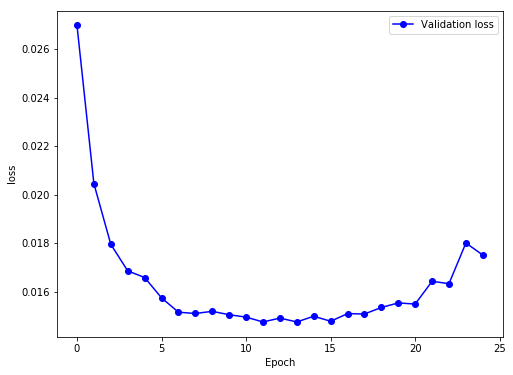

In [21]:
import matplotlib.pyplot as plt

log_val = save_best_model.get_loss_metrics()
idx = np.arange(len(log_val))
plt.figure(figsize=(8, 6))
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.plot(idx, log_val, 'o', linestyle='-', color="b",
             label="Validation loss")
plt.legend()
plt.show()    

An exponential decay is a good sign that the model kept minimizing the prediction error for each epoch. In the training data from our sample air quality data set, the graph shows minimum validation loss around the 16th epoch, which is validated by the output from our callback functions which show that the 16th epoch was saved as the best optimized parameters.   

<h1 style="color:#20B3CD;font-size:20px;float:left">Step 5  |  Validating the Model </h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:70%"></div>

Now that we have a trained Environmental forecasting model, we can validate the model with our test data set and see how it does when forcasting the pollution or atomspheric particulate. Remember that in our sample data set, we trained the model with the first 4 years of data and saved data from the final year, 2014, as our test data set. 

In [22]:
# Load the saved model

sym, arg_params, aux_params = mx.model.load_checkpoint("pollution_forecast", 0)
best_model = mx.mod.Module(symbol=sym, context=mx.cpu(), data_names=['data'], 
                    label_names=['target'],)
best_model.bind(data_shapes=test_iter.provide_data, label_shapes=test_iter.provide_label, for_training=False)
best_model.set_params(arg_params=arg_params, aux_params=aux_params, allow_extra=True, allow_missing=True)

In [23]:
# run best model on the test data, returning the forecasted pollution as yhat
test_iter.reset()
yhat = best_model.predict(test_iter).asnumpy()
yhat.shape

(8760, 1)

In [24]:
# our test data 
p_test_X = o_test_X

# add the 
inv_yhat = np.concatenate((yhat, p_test_X[:, 1:]), axis=1)
print(inv_yhat.shape)

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# print the 
inv_yhat

(8760, 8)


array([ 128.00135803,  146.60980225,  158.92971802, ...,    3.89957762,
          4.4761548 ,    3.84464097], dtype=float32)

In [25]:
# scale back the dataset. Remember we normalized it to (0,1)
scaled_test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((scaled_test_y, p_test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
inv_y

array([ 148.,  159.,  181., ...,    0.,    0.,   36.], dtype=float32)

<h1 style="color:#20B3CD;font-size:20px;float:left">Step 6  |  Results Summary</h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:70%"></div>

An RMSE or Root Mean Square Error is a measure of how well our predicted values matched the actual values. In our sample data RMSE tells us how well we predicted the pollution level a day in advance. The lower the RMSE the better. 

In [26]:
# calculate RMSE
import math
import sklearn.metrics

rmse = math.sqrt(sklearn.metrics.mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 29.443


For our sample data set, the RMSE is higher than we'd like, but it's hard to gauge the effect that will have on our predicted pollution levels and whether we'd be able to use the forecast or would need to further refine it in order to derive business or operational value. To get more concrete, let's compare a few sample data points between our prediction and the actual values. 

In [27]:
# some 1:1 one prediction comparisons
print("actual   ", inv_y[:5])
print("predicted", [round(v,1) for v in inv_yhat[:5]])

actual    [ 148.  159.  181.  138.  109.]
predicted [128.0, 146.60001, 158.89999, 182.2, 140.2]


In our comparison of actual to predicted values, there is a wide variability in accuracy from a miss of -16 to +44 ug/m^3. Before we go back and tweak our model, it is worth revisiting the considerable variability in the data set and looking at the volatility of the pollution meaasurement to consider whether our model has an inherent bias for recent measurements. If it does, we may need to consider looking at daily rather than hourly data to smooth out the volatility or whether there is evidence that the sensor became erratic at some point in the 5 year period, in which case we may need to reduce the time periods we consider to those with healthy sensor data.

To summarize, in this Notebook template we ingested mulivariate time series measurements from multiple sensors distributed across Beijing. We performed basic exploration and subsequent visualization of that data and processed the data so that it could be fed to a neural network machine learning model from the MXNet library. Lastly, we performed the training LSTM machine learning model to make predictions of air quality and test the performance of our model against our testing data. This Notebook demonstrates how we can use machine learning to forecast environmental conditions from long term historical data across any number of IoT use cases and industries.

<div style="height:60px;"><div style="height:7px;background-color:#20B3CD;width:100%;margin-top:20px;position:relative;"><img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="height:50px;width:50px;margin-top:-20px;position:absolute;margin-left:42%;"></div></div>